In [39]:
import csv
import re
from io import BytesIO
import requests
import pdfplumber
import os
import pikepdf
import pandas as pd
import tabula
from bs4 import BeautifulSoup
from PyPDF2 import PdfReader, PdfWriter
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
from fuzzywuzzy import process
import geopandas as gpd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

## 0. Leitura dos Ficheiros

In [2]:
# Guardar todos os outputs numa única pasta
# output_folder = Path.cwd() / "output"
# output_folder.mkdir(parents=True, exist_ok=True)

# Exemplo: mapa.save(output_folder / 'mapa_de_calor_portugal_Danielle.html')

In [3]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

## 1. Incêndios

In [4]:
file_path = data_folder / "Dados Incêndios Urbanos por Freguesia 2014-2021 ISCTE.xlsx"
Fogo = pd.read_excel(file_path)
Fogo

,Ano,Mês,Distrito,CIM,DICO,Concelho,DICOFRE,Freguesia,CodNatureza,Natureza,Ocorrências,MeiosTerrestres,Duração Minutos
0,2014,1.0,Aveiro,Região de Aveiro,101.0,Águeda,10119,Valongo do Vouga,2101.0,Riscos Tecnológicos / Incêndios Urbanos ou em ...,1.0,1.0,61.0
1,2014,1.0,Aveiro,Região de Aveiro,101.0,Águeda,10121,Águeda e Borralha,2101.0,Riscos Tecnológicos / Incêndios Urbanos ou em ...,1.0,1.0,27.0
2,2014,1.0,Aveiro,Região de Aveiro,102.0,Albergaria-a-Velha,10209,Albergaria-a-Velha e Valmaior,2101.0,Riscos Tecnológicos / Incêndios Urbanos ou em ...,1.0,4.0,259.0
3,2014,1.0,Aveiro,Região de Aveiro,103.0,Anadia,10312,Vila Nova de Monsarros,2101.0,Riscos Tecnológicos / Incêndios Urbanos ou em ...,1.0,1.0,48.0
4,2014,1.0,Aveiro,Região de Aveiro,103.0,Anadia,10313,Vilarinho do Bairro,2101.0,Riscos Tecnológicos / Incêndios Urbanos ou em ...,1.0,2.0,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44439,2021,12.0,Viseu,Viseu Dão Lafões,1823.0,Viseu,182321,Ranhados,2101.0,Riscos Tecnológicos / Incêndios Urbanos ou em ...,1.0,3.0,110.0
44440,2021,12.0,Viseu,Viseu Dão Lafões,1823.0,Viseu,182338,Faíl e Vila Chã de Sá,2101.0,Riscos Tecnológicos / Incêndios Urbanos ou em ...,1.0,2.0,68.0
44441,2021,12.0,Viseu,Viseu Dão Lafões,1823.0,Viseu,182341,Viseu,2101.0,Riscos Tecnológicos / Incêndios Urbanos ou em ...,3.0,7.0,207.0
44442,2021,12.0,Viseu,Viseu Dão Lafões,1824.0,Vouzela,182414,Fataunços e Figueiredo Das Donas,2101.0,Riscos Tecnológicos / Incêndios Urbanos ou em ...,1.0,2.0,140.0


In [5]:
Fogo["Natureza"] = Fogo["Natureza"].str.split('/').str[-1].str.strip()
Fogo.dropna(subset=["Concelho"], inplace=True)
Fogo

,Ano,Mês,Distrito,CIM,DICO,Concelho,DICOFRE,Freguesia,CodNatureza,Natureza,Ocorrências,MeiosTerrestres,Duração Minutos
0,2014,1.0,Aveiro,Região de Aveiro,101.0,Águeda,10119,Valongo do Vouga,2101.0,Habitacional,1.0,1.0,61.0
1,2014,1.0,Aveiro,Região de Aveiro,101.0,Águeda,10121,Águeda e Borralha,2101.0,Habitacional,1.0,1.0,27.0
2,2014,1.0,Aveiro,Região de Aveiro,102.0,Albergaria-a-Velha,10209,Albergaria-a-Velha e Valmaior,2101.0,Habitacional,1.0,4.0,259.0
3,2014,1.0,Aveiro,Região de Aveiro,103.0,Anadia,10312,Vila Nova de Monsarros,2101.0,Habitacional,1.0,1.0,48.0
4,2014,1.0,Aveiro,Região de Aveiro,103.0,Anadia,10313,Vilarinho do Bairro,2101.0,Habitacional,1.0,2.0,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44438,2021,12.0,Viseu,Viseu Dão Lafões,1823.0,Viseu,182301,Abraveses,2101.0,Habitacional,3.0,7.0,171.0
44439,2021,12.0,Viseu,Viseu Dão Lafões,1823.0,Viseu,182321,Ranhados,2101.0,Habitacional,1.0,3.0,110.0
44440,2021,12.0,Viseu,Viseu Dão Lafões,1823.0,Viseu,182338,Faíl e Vila Chã de Sá,2101.0,Habitacional,1.0,2.0,68.0
44441,2021,12.0,Viseu,Viseu Dão Lafões,1823.0,Viseu,182341,Viseu,2101.0,Habitacional,3.0,7.0,207.0


In [6]:
pivot_table = Fogo.pivot_table(Fogo, 
                             index=['Ano', 'Mês', 'Concelho'],
                             columns='Natureza',               
                             aggfunc='size',                   
                             fill_value=0)                     

pivot_table

Natureza                      Bibliotecas e Arquivos  Desporto e Lazer  \
Ano  Mês  Concelho                                                       
2014 1.0  Abrantes                                 0                 0   
          Aguiar da Beira                          0                 0   
          Albergaria-a-Velha                       0                 0   
          Albufeira                                0                 0   
          Alcanena                                 0                 0   
...                                              ...               ...   
2021 12.0 Vouzela                                  0                 0   
          Águeda                                   0                 0   
          Évora                                    0                 0   
          Ílhavo                                   0                 0   
          Óbidos                                   0                 0   

Natureza                      Edifícios degradados ou devolutos  \
Ano  Mês  Concelho                                                
2014 1.0  Abrantes                                            0   
          Aguiar da Beira                                     0   
          Albergaria-a-Velha                                  0   
          Albufeira                                           0   
          Alcanena                                            0   
...                                                         ...   
2021 12.0 Vouzela                                             0   
          Águeda                                              0   
          Évora                                               0   
          Ílhavo                                              0   
          Óbidos                                              0   

Natureza                      Espectáculos e Reuniões Públicas  \
Ano  Mês  Concelho                                               
2014 1.0  Abrantes                                           0   
          Aguiar da Beira                                    0   
          Albergaria-a-Velha                                 0   
          Albufeira                                          0   
          Alcanena                                           0   
...                                                        ...   
2021 12.0 Vouzela                                            0   
          Águeda                                             0   
          Évora                                              0   
          Ílhavo                                             0   
          Óbidos                                             0   

Natureza                      Estacionamento de superfície  \
Ano  Mês  Concelho                                           
2014 1.0  Abrantes                                       0   
          Aguiar da Beira                                0   
          Albergaria-a-Velha                             0   
          Albufeira                                      0   
          Alcanena                                       0   
...                                                    ...   
2021 12.0 Vouzela                                        0   
          Águeda                                         0   
          Évora                                          0   
          Ílhavo                                         0   
          Óbidos                                         0   

Natureza                      Estacionamento em profundidade ou silo  \
Ano  Mês  Concelho                                                     
2014 1.0  Abrantes                                                 0   
          Aguiar da Beira                                          0   
          Albergaria-a-Velha                                       0   
          Albufeira                                                0   
          Alcanena                                                 

In [7]:
FogoPosto = Fogo.groupby(["Ano", "Mês", "Concelho"])[["Ocorrências", "MeiosTerrestres", "Duração Minutos"]].sum()
FogoPosto

Ocorrências  MeiosTerrestres  Duração Minutos
Ano  Mês  Concelho                                                         
2014 1.0  Abrantes                    1.0              1.0             44.0
          Aguiar da Beira             1.0              2.0             85.0
          Albergaria-a-Velha          1.0              4.0            259.0
          Albufeira                   1.0              3.0            107.0
          Alcanena                    3.0              4.0            133.0
...                                   ...              ...              ...
2021 12.0 Vouzela                     1.0              2.0            140.0
          Águeda                      1.0              1.0             39.0
          Évora                       2.0              7.0            327.0
          Ílhavo                      1.0              6.0            521.0
          Óbidos                      2.0              5.0            438.0

[16686 rows x 3 columns]

In [8]:
FogoFinal = pd.merge(pivot_table, FogoPosto, how='inner', on=['Ano', 'Mês', 'Concelho'])
FogoFinal

Bibliotecas e Arquivos  Desporto e Lazer  \
Ano  Mês  Concelho                                                       
2014 1.0  Abrantes                                 0                 0   
          Aguiar da Beira                          0                 0   
          Albergaria-a-Velha                       0                 0   
          Albufeira                                0                 0   
          Alcanena                                 0                 0   
...                                              ...               ...   
2021 12.0 Vouzela                                  0                 0   
          Águeda                                   0                 0   
          Évora                                    0                 0   
          Ílhavo                                   0                 0   
          Óbidos                                   0                 0   

                              Edifícios degradados ou devolutos  \
Ano  Mês  Concelho                                                
2014 1.0  Abrantes                                            0   
          Aguiar da Beira                                     0   
          Albergaria-a-Velha                                  0   
          Albufeira                                           0   
          Alcanena                                            0   
...                                                         ...   
2021 12.0 Vouzela                                             0   
          Águeda                                              0   
          Évora                                               0   
          Ílhavo                                              0   
          Óbidos                                              0   

                              Espectáculos e Reuniões Públicas  \
Ano  Mês  Concelho                                               
2014 1.0  Abrantes                                           0   
          Aguiar da Beira                                    0   
          Albergaria-a-Velha                                 0   
          Albufeira                                          0   
          Alcanena                                           0   
...                                                        ...   
2021 12.0 Vouzela                                            0   
          Águeda                                             0   
          Évora                                              0   
          Ílhavo                                             0   
          Óbidos                                             0   

                              Estacionamento de superfície  \
Ano  Mês  Concelho                                           
2014 1.0  Abrantes                                       0   
          Aguiar da Beira                                0   
          Albergaria-a-Velha                             0   
          Albufeira                                      0   
          Alcanena                                       0   
...                                                    ...   
2021 12.0 Vouzela                                        0   
          Águeda                                         0   
          Évora                                          0   
          Ílhavo                                         0   
          Óbidos                                         0   

                              Estacionamento em profundidade ou silo  \
Ano  Mês  Concelho                                                     
2014 1.0  Abrantes                                                 0   
          Aguiar da Beira                                          0   
          Albergaria-a-Velha                                       0   
          Albufeira                                                0   
          Alcanena                                                 0   
...                      

## 2. Densidade Populacional

In [9]:
file_path = data_folder / "PORDATA_Densidade-populacional.xlsx"
Denso = pd.read_excel(file_path, header=11, usecols=range(17))
Denso.drop("Âmbito Geográfico", axis=1, inplace=True)
Denso = Denso.dropna()
Denso.drop(334, inplace=True)
Denso.rename(columns={'Anos': "Concelho"}, inplace=True)
Denso["Concelho"] = Denso["Concelho"].str.title()
Denso

,Concelho,2001,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Arcos De Valdevez,55.2,52,51.5,50.6,49.7,49,48.4,47.9,47.4,47.1,46.8,46.6,46.5,46.4,46.2
1,Caminha,124.1,123.4,122.9,122.5,121.9,120.9,119.7,118.5,117.5,116.8,116.3,116.1,116.2,116.6,117.4
2,Melgaço,41.9,39.4,39,38.3,37.5,36.9,36.3,35.8,35.3,34.7,34.1,33.7,33.2,32.5,32.1
3,Monção,94.3,92,91.5,90.8,89.9,88.9,87.8,86.9,86.1,85.5,85,84.7,84.8,84.7,84.6
4,Paredes De Coura,69.1,67.2,66.9,66.1,65.3,64.8,64.2,63.8,63.4,63,62.8,62.8,63,63,62.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,Ribeira Brava,193,204.3,204.6,204.6,203.5,201.2,198.1,195,192.9,192,192.3,193.7,194.8,195.3,196.2
304,Santa Cruz,448.9,505,520.4,528.3,527.2,523.7,519.1,514.5,511.5,510.4,510.7,512.3,518,524.7,531.2
305,Santana,91.2,83.1,81.6,80.1,78.5,77,75.4,73.8,72.4,71.2,70.4,69.9,69.4,68.6,68
306,São Vicente,76.5,74.1,73.2,71.7,70,68.5,66.6,65,63.8,62.8,62.1,61.7,61.8,61.8,61.7


## 3. População Residente

In [10]:
file_path = data_folder / "PORDATA_NUTS2013_Total.xlsx"
Viver = pd.read_excel(file_path, header=11, usecols=range(25))
Viver.drop("Âmbito Geográfico", axis=1, inplace=True)
Viver = Viver.dropna()
Viver.drop(333, inplace=True)
Viver.rename(columns={'Anos': "Concelho"}, inplace=True)
Viver["Concelho"] = Denso["Concelho"].str.title()
Viver

,Concelho,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Arcos De Valdevez,0,24686,24603,24448,24259,24062,23854,23692,23519,...,21944,21664,21420,21227,21076,20926,20844,20826,20754,20693
1,Caminha,0,17055,17100,17088,17051,17013,16986,16959,16892,...,16500,16345,16177,16045,15940,15873,15848,15863,15917,16033
2,Melgaço,0,9971,9949,9889,9796,9715,9630,9538,9465,...,8785,8652,8531,8418,8279,8136,8029,7901,7755,7648
3,Monção,0,19925,19950,19919,19843,19773,19698,19615,19536,...,18782,18556,18361,18199,18063,17953,17890,17909,17898,17868
4,Paredes De Coura,0,9565,9556,9509,9459,9429,9404,9368,9321,...,8952,8869,8811,8761,8706,8677,8685,8711,8703,8676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,Ribeira Brava,0,12523,12683,12827,12971,13087,13165,13247,13316,...,13158,12969,12765,12625,12570,12585,12679,12749,12788,12841
304,Santa Cruz,0,30301,31734,33120,34466,35805,37154,38512,39847,...,42685,42307,41932,41690,41602,41625,41753,42115,42666,43190
305,Santana,0,8750,8685,8605,8511,8395,8276,8169,8062,...,7357,7204,7049,6911,6800,6722,6677,6624,6554,6490
306,São Vicente,0,6179,6174,6138,6078,6020,5979,5946,5904,...,5398,5255,5124,5027,4949,4897,4867,4872,4875,4861


## 4. Setor de Atividade

### 4.1. Primário

In [11]:
file_path = data_folder / "SetorDeAtividade.xlsx"
WorkP = pd.read_excel(file_path, header=11, usecols=[0,1,6,7])
WorkP.drop("Âmbito Geográfico", axis=1, inplace=True)
WorkP = WorkP.dropna()
WorkP.drop(333, inplace=True)
WorkP.rename(columns={'Anos': "Concelho"}, inplace=True)
WorkP["Concelho"] = WorkP["Concelho"].str.title()
WorkP

,Concelho,2011,2021
0,Arcos De Valdevez,514,374
1,Caminha,316,213
2,Melgaço,258,193
3,Monção,377,432
4,Paredes De Coura,185,151
...,...,...,...
303,Ribeira Brava,156,119
304,Santa Cruz,439,318
305,Santana,410,229
306,São Vicente,100,105


### 4.2. Secundário

In [12]:
file_path = data_folder / "SetorDeAtividade.xlsx"
WorkS = pd.read_excel(file_path, header=11, usecols=[0,1,12,13])
WorkS.drop("Âmbito Geográfico", axis=1, inplace=True)
WorkS = WorkS.dropna()
WorkS.drop(333, inplace=True)
WorkS.rename(columns={'2011.1': 2011}, inplace=True)
WorkS.rename(columns={'2021.1': 2021}, inplace=True)
WorkS.rename(columns={'Anos': "Concelho"}, inplace=True)
WorkS["Concelho"] = WorkS["Concelho"].str.title()
WorkS

,Concelho,2011,2021
0,Arcos De Valdevez,2369,2486
1,Caminha,1561,1634
2,Melgaço,595,579
3,Monção,2062,2058
4,Paredes De Coura,1253,1513
...,...,...,...
303,Ribeira Brava,1327,994
304,Santa Cruz,2777,2260
305,Santana,438,348
306,São Vicente,449,293


### 4.3. Setor Terciário

In [13]:
file_path = data_folder / "SetorDeAtividade.xlsx"
WorkT = pd.read_excel(file_path, header=11, usecols=[0,1,18,19])
WorkT.drop("Âmbito Geográfico", axis=1, inplace=True)
WorkT = WorkT.dropna()
WorkT.drop(333, inplace=True)
WorkT.rename(columns={'2011.2': 2011}, inplace=True)
WorkT.rename(columns={'2021.2': 2021}, inplace=True)
WorkT.rename(columns={'Anos': "Concelho"}, inplace=True)
WorkT["Concelho"] = WorkT["Concelho"].str.title()
WorkT

,Concelho,2011,2021
0,Arcos De Valdevez,4175,4141
1,Caminha,4386,4438
2,Melgaço,1767,1657
3,Monção,4077,4182
4,Paredes De Coura,1910,1750
...,...,...,...
303,Ribeira Brava,3454,3441
304,Santa Cruz,16902,16317
305,Santana,1855,1722
306,São Vicente,1351,1281


## 5. Indíce de Envelhecimento

In [14]:
file_path = data_folder / "IndiceEnvelhecimento.xlsx"
Velho = pd.read_excel(file_path, header=11, usecols=range(25))
Velho.drop("Âmbito Geográfico", axis=1, inplace=True)
Velho.dropna(inplace=True)
Velho.drop(333, inplace=True)
Velho.rename(columns={'Anos': "Concelho"}, inplace=True)
Velho["Concelho"] = Velho["Concelho"].str.title()
Velho

,Concelho,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Arcos De Valdevez,0,208.1,216.4,223.7,231.3,238.7,244,248.3,253.1,...,273.1,282.8,296,310.1,324.8,339.6,355.1,369.2,379.3,391.6
1,Caminha,0,138.1,141.1,145,147.3,149.9,153.1,156.4,161.3,...,203.4,209.8,218.9,229.2,239.7,247.6,253.3,258.9,265.8,272.3
2,Melgaço,0,297.4,305.3,311.1,321.1,332.3,348.2,367.2,376.7,...,393.4,410.7,433.9,451.1,473.6,501,526.9,548.2,563.3,577
3,Monção,0,209.7,217.6,222.3,227.2,234.8,242,246.3,246.3,...,277.2,284.3,292.3,301,310.2,318.2,324.1,332.2,343.5,351.5
4,Paredes De Coura,0,204.6,208.8,211.6,214.2,216.5,218.1,216.2,213.4,...,219,226,232.5,237.7,244.3,250.3,256.3,267.3,278.4,289.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,Ribeira Brava,0,80.9,81,78.5,76.5,76.1,76,76,76.9,...,96.4,102.2,108,114.8,122.5,131.4,141.7,152,162.1,169.5
304,Santa Cruz,0,56.1,55.4,54.4,53.1,52.1,51.2,50.4,49.7,...,57.9,60.8,63.9,67.8,72.7,78.1,83.8,89.9,95.7,101.1
305,Santana,0,128.1,136.8,143.8,149,151.7,153.7,159.1,165.3,...,189.7,201.1,211.2,222.4,234.8,242.8,253,265.4,279.7,290.4
306,São Vicente,0,121.5,127,131.1,133.7,136.7,141.1,146,152,...,169.4,180.6,190.5,197.8,206,215.3,228.4,243.7,258.3,273.9


## 6. Zonas Rurais

In [15]:
file_path = data_folder / "ZonasCount.csv"
ZonasRurais = pd.read_csv(file_path)
ZonasRurais["Rural"] = ZonasRurais["Zona Rural"] / (ZonasRurais["Zona Urbana"] + ZonasRurais["Zona Rural"])
ZonasRurais

,Distrito,Concelho,Zona Rural,Zona Urbana,Rural
0,Aveiro,Albergaria-A-Velha,6,0,1.00
1,Aveiro,Anadia,10,0,1.00
2,Aveiro,Arouca,16,0,1.00
3,Aveiro,Aveiro,0,10,0.00
4,Aveiro,Castelo De Paiva,6,0,1.00
...,...,...,...,...,...
273,Évora,Reguengos De Monsaraz,4,0,1.00
274,Évora,Vendas Novas,2,0,1.00
275,Évora,Viana Do Alentejo,3,0,1.00
276,Évora,Vila Viçosa,4,0,1.00


## 7. IPMA

In [16]:
# Caminho do arquivo Excel
file_path = data_folder / "Dados_diarios_T_Vento_Prec_capitaisDistrito_2013_a_2023.xlsx"

# Lista de nomes dos distritos
distritos = ['Viana do Castelo', 'Braga', 'Vila Real', 'Bragança', 'Porto', 'Aveiro', 'Viseu', 'Guarda',
             'Coimbra', 'Castelo Branco', 'Leiria', 'Santarém', 'Portalegre', 'Lisboa', 'Setúbal', 'Évora',
             'Beja', 'Faro']

# Lista completa de colunas a serem lidas
colunasTempo = ['Ano', 'Mês', 'Dia'] + distritos

colunas_indices = list(range(len(colunasTempo)))

# Leitura do arquivo Excel para cada tabela
T_MED = pd.read_excel(file_path, sheet_name=1, names=colunasTempo)
T_MAX = pd.read_excel(file_path, sheet_name=2, names=colunasTempo)
T_MIN = pd.read_excel(file_path, sheet_name=3, names=colunasTempo)
DD_MED = pd.read_excel(file_path, sheet_name=4, names=colunasTempo)
DD_FFX = pd.read_excel(file_path, sheet_name=5, names=colunasTempo)
FF_MED = pd.read_excel(file_path, sheet_name=6, names=colunasTempo)
FF_MAX = pd.read_excel(file_path, sheet_name=7, names=colunasTempo)
PR_QTD = pd.read_excel(file_path, sheet_name=8, names=colunasTempo)

tabelas = [T_MED, T_MAX, T_MIN, DD_MED, DD_FFX, FF_MED, FF_MAX, PR_QTD]
for i in tabelas:
    i.rename(columns={'Viana do Castelo': "Viana Do Castelo"}, inplace=True)

T_MED

,Ano,Mês,Dia,Viana Do Castelo,Braga,Vila Real,Bragança,Porto,Aveiro,Viseu,...,Coimbra,Castelo Branco,Leiria,Santarém,Portalegre,Lisboa,Setúbal,Évora,Beja,Faro
0,2013,1,1,9.6,9.0,8.2,7.2,10.5,10.5,7.3,...,10.3,8.0,9.9,10.4,7.9,12.3,11.9,9.4,10.2,13.6
1,2013,1,2,7.9,7.1,6.6,4.8,9.0,10.0,7.3,...,9.0,9.2,7.3,10.4,9.0,11.8,11.7,8.8,9.0,12.7
2,2013,1,3,8.6,9.2,7.6,5.9,11.5,13.4,8.3,...,11.3,9.0,7.6,10.0,9.4,10.9,9.7,7.6,8.9,13.0
3,2013,1,4,8.0,7.3,7.0,5.4,11.1,11.0,9.4,...,11.2,7.8,7.7,9.4,9.3,9.9,7.3,7.6,8.7,13.2
4,2013,1,5,6.6,5.8,6.2,5.2,9.2,9.3,9.7,...,9.5,8.3,7.8,9.4,10.2,10.5,8.0,7.9,9.8,13.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4012,2023,12,27,13.3,-990.0,2.2,0.4,11.5,-990.0,7.3,...,8.2,2.7,7.7,7.6,5.6,7.7,8.0,5.0,6.2,10.9
4013,2023,12,28,12.7,-990.0,6.9,4.6,13.6,-990.0,8.8,...,12.0,6.1,10.9,9.5,9.7,9.8,10.2,7.8,9.2,13.4
4014,2023,12,29,12.0,-990.0,9.2,7.0,12.2,-990.0,9.3,...,12.1,7.4,12.1,9.8,9.5,10.0,9.7,8.9,10.2,14.5
4015,2023,12,30,12.6,-990.0,9.7,7.8,12.6,-990.0,9.0,...,11.2,8.4,11.3,11.0,10.0,10.9,9.9,8.2,10.8,13.9


## 8. Eventos Excecionais

In [17]:
file_path = data_folder / "eventos.parquet"
Quebras = pd.read_parquet(file_path)
Quebras.dropna(inplace=True)
Quebras.reset_index(drop = True, inplace=True)
Quebras['Ano'] = Quebras['data_do_incidente'].dt.year
Quebras['Mês'] = Quebras['data_do_incidente'].dt.month
Quebras['Dia'] = Quebras['data_do_incidente'].dt.day
Quebras.rename(columns={'concelho_origem_do_incidente': "Concelho"}, inplace=True)
Quebras["Concelho"] = Quebras["Concelho"].str.title()
Quebras['aprovado'] = Quebras['aprovado'].astype(int)
mapeamento = {'BT': 1, 'MT': 2, 'AT': 3}
Quebras['nt'] = Quebras['nt'].map(mapeamento)
Quebras

,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,saifi_bt_number,saidi_bt_min,nt,aprovado,Ano,Mês,Dia
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,0.049000,2.667000,3,1,2023,11,1
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,0.000230,0.001139,2,1,2023,10,9
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,0.000116,0.004531,2,1,2023,10,9
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,0.000517,0.004441,2,1,2023,10,13
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,0.000039,0.003832,2,1,2023,10,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,10.000000,0.000880,2,1,2014,6,10
5236,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,259.000000,0.023300,2,1,2014,6,24
5237,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,235.000000,0.017800,2,1,2014,6,7
5238,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,302.000000,0.020900,2,1,2014,6,18


## 9. Junção dos dados

### 9.1. Distritos

In [18]:
file_path = shape_folder / "concelhos.shp"
Concelho = gpd.read_file(file_path)
Concelho
Concelho.rename(columns={'NAME_1': 'Distrito'}, inplace=True)
Concelho.rename(columns={'NAME_2': 'Concelho'}, inplace=True)
Concelho['Concelho'] = Concelho['Concelho'].str.title()
Concelho['Distrito'] = Concelho['Distrito'].str.title()

# Crie um dicionário vazio para armazenar os concelhos de cada distrito
dicionario_concelhos = {}

# Itere sobre os distritos únicos na coluna 'Distrito'
for distrito in Concelho['Distrito'].unique():
    # Filtrar os concelhos para o distrito atual
    concelhos_distrito = Concelho.loc[Concelho['Distrito'] == distrito, 'Concelho'].tolist()
    # Adicionar os concelhos ao dicionário
    dicionario_concelhos[distrito] = concelhos_distrito
dicionario_concelhos['Braga'].append('Guimarães')
dicionario_concelhos['Portalegre'].append('Ponte De Sor')
dicionario_concelhos['Faro'].append('Tavira')

In [19]:
def mapear_distrito(concelho):
    for distrito, concelhos in dicionario_concelhos.items():
        if concelho in concelhos:
            return distrito
    return None  # Retorna None se o concelho não for encontrado no dicionário

# Aplicar a função mapear_distrito à coluna 'Concelhos' e criar uma nova coluna 'Distrito' no DataFrame Quebras
Quebras['Distrito'] = Quebras['Concelho'].apply(mapear_distrito)
Quebras = Quebras[Quebras['Distrito'] != 'Azores']
Quebras = Quebras.dropna()
Quebras

,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,saifi_bt_number,saidi_bt_min,nt,aprovado,Ano,Mês,Dia,Distrito
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,0.049000,2.667000,3,1,2023,11,1,Braga
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,0.000230,0.001139,2,1,2023,10,9,Braga
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,0.000116,0.004531,2,1,2023,10,9,Coimbra
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,0.000517,0.004441,2,1,2023,10,13,Porto
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,0.000039,0.003832,2,1,2023,10,22,Setúbal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,10.000000,0.000880,2,1,2014,6,10,Aveiro
5236,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,259.000000,0.023300,2,1,2014,6,24,Viseu
5237,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,235.000000,0.017800,2,1,2014,6,7,Coimbra
5238,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,302.000000,0.020900,2,1,2014,6,18,Leiria


## 9.2. Incêndios - TODO

In [20]:
# Juntar a Base de dados dos incêndios
# Quebras = pd.merge(Quebras, FogoFinal, on=['Ano', 'Mês', 'Concelho'], how='left')
# Quebras

## 9.3. Densidade Populacional

In [21]:
for index, row in Quebras.iterrows():
    # Obtendo o ano e o concelho da linha atual
    ano = row['Ano']
    if ano == 2023:
        ano = 2022
    concelho = row['Concelho']
    
    # Verificando se o ano existe como coluna na tabela 'Denso'
    if ano in Denso.columns:
        # Verificando se o concelho está presente na tabela 'Denso'
        if concelho in Denso['Concelho'].values:
            # Filtrando a linha correspondente na tabela 'Denso' com base no concelho
            linha_denso = Denso[Denso['Concelho'] == concelho]
            
            # Obtendo o valor para o ano desejado
            valor = linha_denso[ano].values[0]
        else:
            # Atribuindo valor nulo se o concelho não estiver presente na tabela 'Denso'
            valor = None
    else:
        # Atribuindo valor nulo se o ano não estiver presente como coluna na tabela 'Denso'
        valor = None
    
    # Atualizando a linha 'Quebras' com o valor obtido
    Quebras.at[index, 'Densidade Populacional'] = valor

Quebras


,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,saifi_bt_number,saidi_bt_min,nt,aprovado,Ano,Mês,Dia,Distrito,Densidade Populacional
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,0.049000,2.667000,3,1,2023,11,1,Braga,307.6
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,0.000230,0.001139,2,1,2023,10,9,Braga,97.2
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,0.000116,0.004531,2,1,2023,10,9,Coimbra,95.3
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,0.000517,0.004441,2,1,2023,10,13,Porto,2813.7
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,0.000039,0.003832,2,1,2023,10,22,Setúbal,26.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,10.000000,0.000880,2,1,2014,6,10,Aveiro,139.7
5236,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,259.000000,0.023300,2,1,2014,6,24,Viseu,195.7
5237,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,235.000000,0.017800,2,1,2014,6,7,Coimbra,160.4
5238,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,302.000000,0.020900,2,1,2014,6,18,Leiria,90.8


## 9.4. População Residente

In [22]:
for index, row in Quebras.iterrows():
    # Obtendo o ano e o concelho da linha atual
    ano = row['Ano']
    if ano == 2023:
        ano = 2022
    concelho = row['Concelho']
    
    # Verificando se o ano existe como coluna na tabela 'Denso'
    if ano in Viver.columns:
        # Verificando se o concelho está presente na tabela 'Denso'
        if concelho in Viver['Concelho'].values:
            # Filtrando a linha correspondente na tabela 'Denso' com base no concelho
            linha_denso = Viver[Viver['Concelho'] == concelho]
            
            # Obtendo o valor para o ano desejado
            valor = linha_denso[ano].values[0]
        else:
            # Atribuindo valor nulo se o concelho não estiver presente na tabela 'Denso'
            valor = None
    else:
        # Atribuindo valor nulo se o ano não estiver presente como coluna na tabela 'Denso'
        valor = None
    
    # Atualizando a linha 'Quebras' com o valor obtido
    Quebras.at[index, 'População Residente'] = valor

Quebras


,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,saifi_bt_number,saidi_bt_min,nt,aprovado,Ano,Mês,Dia,Distrito,Densidade Populacional,População Residente
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,0.049000,2.667000,3,1,2023,11,1,Braga,307.6,116568.0
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,0.000230,0.001139,2,1,2023,10,9,Braga,97.2,17601.0
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,0.000116,0.004531,2,1,2023,10,9,Coimbra,95.3,12046.0
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,0.000517,0.004441,2,1,2023,10,13,Porto,2813.7,175631.0
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,0.000039,0.003832,2,1,2023,10,22,Setúbal,26.5,28050.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,10.000000,0.000880,2,1,2014,6,10,Aveiro,139.7,46827.0
5236,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,259.000000,0.023300,2,1,2014,6,24,Viseu,195.7,99220.0
5237,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,235.000000,0.017800,2,1,2014,6,7,Coimbra,160.4,60813.0
5238,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,302.000000,0.020900,2,1,2014,6,18,Leiria,90.8,23761.0


## 9.5. Setores de Atividade

### 9.5.1. Primário

In [23]:
for index, row in Quebras.iterrows():
    # Obtendo o ano da linha atual de 'Quebras'
    ano_quebras = row['Ano']
    
    # Obtendo os anos disponíveis na tabela 'WorkP'
    anos_workp = [str(col) for col in WorkP.columns[1:]]  # Convertendo os anos para strings
    
    # Verificando se o ano de 2021 está presente
    if '2021' in anos_workp:
        # Encontrando o ano mais próximo na tabela 'WorkP'
        ano_proximo = min(anos_workp, key=lambda x: abs(int(x) - ano_quebras))
        
        # Obtendo o valor da coluna correspondente ao ano mais próximo
        valor = WorkP[int(ano_proximo)].values[0]
    
    # Atualizando a linha 'Quebras' com o valor obtido
    Quebras.at[index, 'Setor Primário'] = valor

Quebras

,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,...,saidi_bt_min,nt,aprovado,Ano,Mês,Dia,Distrito,Densidade Populacional,População Residente,Setor Primário
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,...,2.667000,3,1,2023,11,1,Braga,307.6,116568.0,374.0
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,...,0.001139,2,1,2023,10,9,Braga,97.2,17601.0,374.0
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,...,0.004531,2,1,2023,10,9,Coimbra,95.3,12046.0,374.0
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,...,0.004441,2,1,2023,10,13,Porto,2813.7,175631.0,374.0
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,...,0.003832,2,1,2023,10,22,Setúbal,26.5,28050.0,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,...,0.000880,2,1,2014,6,10,Aveiro,139.7,46827.0,514.0
5236,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,...,0.023300,2,1,2014,6,24,Viseu,195.7,99220.0,514.0
5237,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,...,0.017800,2,1,2014,6,7,Coimbra,160.4,60813.0,514.0
5238,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,...,0.020900,2,1,2014,6,18,Leiria,90.8,23761.0,514.0


### 9.5.2. Secundário

In [24]:
for index, row in Quebras.iterrows():
    # Obtendo o ano da linha atual de 'Quebras'
    ano_quebras = row['Ano']
    
    # Obtendo os anos disponíveis na tabela 'WorkS'
    anos_WorkS = [str(col) for col in WorkS.columns[1:]]  # Convertendo os anos para strings
    
    # Verificando se o ano de 2021 está presente
    if '2021' in anos_WorkS:
        # Encontrando o ano mais próximo na tabela 'WorkS'
        ano_proximo = min(anos_WorkS, key=lambda x: abs(int(x) - ano_quebras))
        
        # Obtendo o valor da coluna correspondente ao ano mais próximo
        valor = WorkS[int(ano_proximo)].values[0]
    
    # Atualizando a linha 'Quebras' com o valor obtido
    Quebras.at[index, 'Setor Secundário'] = valor

Quebras

,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,...,nt,aprovado,Ano,Mês,Dia,Distrito,Densidade Populacional,População Residente,Setor Primário,Setor Secundário
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,...,3,1,2023,11,1,Braga,307.6,116568.0,374.0,2486.0
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,...,2,1,2023,10,9,Braga,97.2,17601.0,374.0,2486.0
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,...,2,1,2023,10,9,Coimbra,95.3,12046.0,374.0,2486.0
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,...,2,1,2023,10,13,Porto,2813.7,175631.0,374.0,2486.0
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,...,2,1,2023,10,22,Setúbal,26.5,28050.0,374.0,2486.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,...,2,1,2014,6,10,Aveiro,139.7,46827.0,514.0,2369.0
5236,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,...,2,1,2014,6,24,Viseu,195.7,99220.0,514.0,2369.0
5237,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,...,2,1,2014,6,7,Coimbra,160.4,60813.0,514.0,2369.0
5238,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,...,2,1,2014,6,18,Leiria,90.8,23761.0,514.0,2369.0


### 9.5.3. Terciário

In [25]:
for index, row in Quebras.iterrows():
    # Obtendo o ano da linha atual de 'Quebras'
    ano_quebras = row['Ano']
    
    # Obtendo os anos disponíveis na tabela 'WorkT'
    anos_WorkT = [str(col) for col in WorkT.columns[1:]]  # Convertendo os anos para strings
    
    # Verificando se o ano de 2021 está presente
    if '2021' in anos_WorkT:
        # Encontrando o ano mais próximo na tabela 'WorkT'
        ano_proximo = min(anos_WorkT, key=lambda x: abs(int(x) - ano_quebras))
        
        # Obtendo o valor da coluna correspondente ao ano mais próximo
        valor = WorkT[int(ano_proximo)].values[0]
    
    # Atualizando a linha 'Quebras' com o valor obtido
    Quebras.at[index, 'Setor Terciário'] = valor

Quebras

,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,...,aprovado,Ano,Mês,Dia,Distrito,Densidade Populacional,População Residente,Setor Primário,Setor Secundário,Setor Terciário
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,...,1,2023,11,1,Braga,307.6,116568.0,374.0,2486.0,4141.0
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,...,1,2023,10,9,Braga,97.2,17601.0,374.0,2486.0,4141.0
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,...,1,2023,10,9,Coimbra,95.3,12046.0,374.0,2486.0,4141.0
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,...,1,2023,10,13,Porto,2813.7,175631.0,374.0,2486.0,4141.0
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,...,1,2023,10,22,Setúbal,26.5,28050.0,374.0,2486.0,4141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,...,1,2014,6,10,Aveiro,139.7,46827.0,514.0,2369.0,4175.0
5236,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,...,1,2014,6,24,Viseu,195.7,99220.0,514.0,2369.0,4175.0
5237,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,...,1,2014,6,7,Coimbra,160.4,60813.0,514.0,2369.0,4175.0
5238,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,...,1,2014,6,18,Leiria,90.8,23761.0,514.0,2369.0,4175.0


## 9.6. Indice de Envelhecimento

In [26]:
for index, row in Quebras.iterrows():
    # Obtendo o ano e o concelho da linha atual
    ano = row['Ano']
    if ano == 2023:
        ano = 2022
    concelho = row['Concelho']
    
    # Verificando se o ano existe como coluna na tabela 'Denso'
    if ano in Velho.columns:
        # Verificando se o concelho está presente na tabela 'Denso'
        if concelho in Velho['Concelho'].values:
            # Filtrando a linha correspondente na tabela 'Denso' com base no concelho
            linha_denso = Velho[Velho['Concelho'] == concelho]
            
            # Obtendo o valor para o ano desejado
            valor = linha_denso[ano].values[0]
        else:
            # Atribuindo valor nulo se o concelho não estiver presente na tabela 'Denso'
            valor = None
    else:
        # Atribuindo valor nulo se o ano não estiver presente como coluna na tabela 'Denso'
        valor = None
    
    # Atualizando a linha 'Quebras' com o valor obtido
    Quebras.at[index, 'Indice de Envelhecimento'] = valor

Quebras

,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,...,Ano,Mês,Dia,Distrito,Densidade Populacional,População Residente,Setor Primário,Setor Secundário,Setor Terciário,Indice de Envelhecimento
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,...,2023,11,1,Braga,307.6,116568.0,374.0,2486.0,4141.0,164.2
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,...,2023,10,9,Braga,97.2,17601.0,374.0,2486.0,4141.0,211.0
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,...,2023,10,9,Coimbra,95.3,12046.0,374.0,2486.0,4141.0,259.4
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,...,2023,10,13,Porto,2813.7,175631.0,374.0,2486.0,4141.0,186.5
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,...,2023,10,22,Setúbal,26.5,28050.0,374.0,2486.0,4141.0,234.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5235,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,...,2014,6,10,Aveiro,139.7,46827.0,514.0,2369.0,4175.0,160.2
5236,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,...,2014,6,24,Viseu,195.7,99220.0,514.0,2369.0,4175.0,134.7
5237,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,...,2014,6,7,Coimbra,160.4,60813.0,514.0,2369.0,4175.0,191.4
5238,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,...,2014,6,18,Leiria,90.8,23761.0,514.0,2369.0,4175.0,157.1


## 9.7. tx Ruralidade

In [27]:
Quebras = Quebras.merge(ZonasRurais[['Concelho', 'Rural']], on='Concelho', how='left')
Quebras

,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,...,Mês,Dia,Distrito,Densidade Populacional,População Residente,Setor Primário,Setor Secundário,Setor Terciário,Indice de Envelhecimento,Rural
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,...,11,1,Braga,307.6,116568.0,374.0,2486.0,4141.0,164.2,0.934426
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,...,10,9,Braga,97.2,17601.0,374.0,2486.0,4141.0,211.0,1.000000
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,...,10,9,Coimbra,95.3,12046.0,374.0,2486.0,4141.0,259.4,1.000000
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,...,10,13,Porto,2813.7,175631.0,374.0,2486.0,4141.0,186.5,0.000000
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,...,10,22,Setúbal,26.5,28050.0,374.0,2486.0,4141.0,234.9,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,...,6,10,Aveiro,139.7,46827.0,514.0,2369.0,4175.0,160.2,1.000000
5219,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,...,6,24,Viseu,195.7,99220.0,514.0,2369.0,4175.0,134.7,0.840000
5220,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,...,6,7,Coimbra,160.4,60813.0,514.0,2369.0,4175.0,191.4,1.000000
5221,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,...,6,18,Leiria,90.8,23761.0,514.0,2369.0,4175.0,157.1,1.000000


## 9.8. IPMA

In [28]:
# Lista de todas as tabelas de clima
tabelas_clima = tabelas = [('T_MED', T_MED), ('T_MAX', T_MAX), ('T_MIN', T_MIN), ('DD_MED', DD_MED), ('DD_FFX', DD_FFX), ('FF_MED', FF_MED), ('FF_MAX', FF_MAX), ('PR_QTD', PR_QTD)]

# Iterar sobre todas as tabelas de clima
for tabela in tabelas_clima:
    # Obtendo o nome da tabela
    nome_tabela = tabela[0]
    TabeIPMA = tabela[1]
    # Iterar sobre as linhas de Quebras
    for index, row in Quebras.iterrows():

        ano = int(row['Ano'])
        mes = int(row['Mês'])
        dia = int(row['Dia'])
        concelho = row["Distrito"]

        
        valor = TabeIPMA[concelho][(TabeIPMA["Ano"] == ano) & (TabeIPMA["Mês"] == mes) & (TabeIPMA["Dia"] == dia)].iloc[0]
        
        # Atualizando a linha 'Quebras' com o valor obtido
        Quebras.at[index, f'{nome_tabela}'] = valor

# Exibindo o DataFrame Quebras atualizado
Quebras


,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,...,164.2,0.934426,16.2,19.4,12.7,-990.0,-990.0,-990.0,-990.0,27.5
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,...,211.0,1.000000,21.8,35.1,12.2,242.0,297.0,0.8,4.6,0.0
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,...,259.4,1.000000,24.8,33.7,18.8,51.0,311.0,2.1,7.0,0.0
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,...,186.5,0.000000,21.3,23.8,19.0,154.0,186.0,3.9,14.5,5.8
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,...,234.9,1.000000,15.0,16.3,11.9,20.0,52.0,1.2,7.5,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,...,160.2,1.000000,17.6,20.4,14.1,345.0,309.0,2.3,8.1,0.0
5219,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,...,134.7,0.840000,14.4,19.5,-990.0,317.0,332.0,3.5,14.0,15.0
5220,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,...,191.4,1.000000,16.5,21.1,12.6,188.0,169.0,3.8,10.8,0.2
5221,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,...,157.1,1.000000,18.9,24.1,14.6,348.0,276.0,1.2,6.9,0.0


In [29]:
Quebras.replace(-990.0, None, inplace=True)
Quebras

,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,...,164.2,0.934426,16.2,19.4,12.7,None,None,None,None,27.5
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,...,211.0,1.000000,21.8,35.1,12.2,242.0,297.0,0.8,4.6,0.0
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,...,259.4,1.000000,24.8,33.7,18.8,51.0,311.0,2.1,7.0,0.0
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,...,186.5,0.000000,21.3,23.8,19.0,154.0,186.0,3.9,14.5,5.8
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,...,234.9,1.000000,15.0,16.3,11.9,20.0,52.0,1.2,7.5,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,...,160.2,1.000000,17.6,20.4,14.1,345.0,309.0,2.3,8.1,0.0
5219,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,...,134.7,0.840000,14.4,19.5,None,317.0,332.0,3.5,14.0,15.0
5220,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,...,191.4,1.000000,16.5,21.1,12.6,188.0,169.0,3.8,10.8,0.2
5221,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,...,157.1,1.000000,18.9,24.1,14.6,348.0,276.0,1.2,6.9,0.0


In [59]:
ColunasInteressantes = Quebras.columns[4:]
QuebrasFinal = Quebras[ColunasInteressantes]
QuebrasFinal = QuebrasFinal.drop(columns=['Distrito']).copy()
QuebrasFinal

,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,saifi_bt_number,saidi_bt_min,nt,aprovado,...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,0.049000,2.667000,3,1,...,164.2,0.934426,16.2,19.4,12.7,None,None,None,None,27.5
1,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,0.000230,0.001139,2,1,...,211.0,1.000000,21.8,35.1,12.2,242.0,297.0,0.8,4.6,0.0
2,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,0.000116,0.004531,2,1,...,259.4,1.000000,24.8,33.7,18.8,51.0,311.0,2.1,7.0,0.0
3,31.0,3185.0,0.010268,0.000347,0.005273,0.736786,0.000517,0.004441,2,1,...,186.5,0.000000,21.3,23.8,19.0,154.0,186.0,3.9,14.5,5.8
4,130.0,238.0,0.004813,0.000200,0.020169,0.345438,0.000039,0.003832,2,1,...,234.9,1.000000,15.0,16.3,11.9,20.0,52.0,1.2,7.5,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,93.0,61.0,0.012900,126.000000,0.009640,0.830000,10.000000,0.000880,2,1,...,160.2,1.000000,17.6,20.4,14.1,345.0,309.0,2.3,8.1,0.0
5219,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,259.000000,0.023300,2,1,...,134.7,0.840000,14.4,19.5,None,317.0,332.0,3.5,14.0,15.0
5220,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,235.000000,0.017800,2,1,...,191.4,1.000000,16.5,21.1,12.6,188.0,169.0,3.8,10.8,0.2
5221,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,302.000000,0.020900,2,1,...,157.1,1.000000,18.9,24.1,14.6,348.0,276.0,1.2,6.9,0.0


In [60]:
# 1. Estandardização
scaler = StandardScaler()
QuebrasFinal_scaled = scaler.fit_transform(QuebrasFinal)

# 2. Imputação por Regressão
imputer = IterativeImputer()
QuebrasFinal_imputed = imputer.fit_transform(QuebrasFinal_scaled)

# Converter de volta para DataFrame, se necessário
QuebrasFinal_imputed = pd.DataFrame(QuebrasFinal_imputed, columns=QuebrasFinal.columns)

QuebrasFinal_imputed

C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,saifi_bt_number,saidi_bt_min,nt,aprovado,...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,0.244289,42.298595,-0.012112,-0.204619,5.595312,-0.029442,-0.181833,-0.012949,2.738205,1.183332,...,-0.456608,0.555781,-0.031611,-0.406750,0.226092,0.199437,-0.911271,-0.763563,1.096567,3.094735
1,-0.079365,-0.001616,-0.013847,-0.204653,-0.036698,-0.029618,-0.181867,-0.013843,0.816457,1.183332,...,0.004222,0.711698,1.007588,1.856228,0.125321,0.291299,0.668038,-1.532849,-1.548283,-0.364852
2,-0.064773,0.220154,-0.013846,-0.204653,-0.031144,-0.029618,-0.181867,-0.013842,0.816457,1.183332,...,0.480806,0.711698,1.564301,1.654434,1.455498,-1.445101,0.806698,-0.600824,-0.858820,-0.364852
3,-0.069637,0.305597,-0.013839,-0.204653,-0.028974,-0.029617,-0.181866,-0.013842,0.816457,1.183332,...,-0.237025,-1.666030,0.914802,0.227460,1.495806,-0.508718,-0.431340,0.689671,1.295750,0.364806
4,-0.032594,-0.206193,-0.013844,-0.204653,0.000769,-0.029617,-0.181867,-0.013842,0.816457,1.183332,...,0.239560,0.711698,-0.254296,-0.853581,0.064859,-1.726925,-1.758516,-1.246072,-0.715182,-0.075505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,-0.046438,-0.236932,-0.013836,-0.122284,-0.020254,-0.029617,-0.174882,-0.013843,0.816457,1.183332,...,-0.495996,0.711698,0.228189,-0.262612,0.508251,1.227682,0.786890,-0.457436,-0.542817,-0.364852
5219,-0.016505,0.386698,-0.013834,-0.062141,0.011015,-0.029617,-0.000964,-0.013835,0.816457,1.183332,...,-0.747089,0.331262,-0.365639,-0.392337,-0.263682,0.973131,1.014689,0.402894,1.152112,1.522195
5220,-0.018376,0.109356,-0.013842,-0.024225,0.002429,-0.029617,-0.017727,-0.013837,0.816457,1.183332,...,-0.188776,0.711698,0.024061,-0.161715,0.205938,-0.199620,-0.599713,0.617977,0.232829,-0.339691
5221,0.021286,0.070976,-0.013839,0.020882,0.016007,-0.029617,0.029070,-0.013836,0.816457,1.183332,...,-0.526521,0.711698,0.469431,0.270702,0.609022,1.254955,0.460048,-1.246072,-0.887548,-0.364852


C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

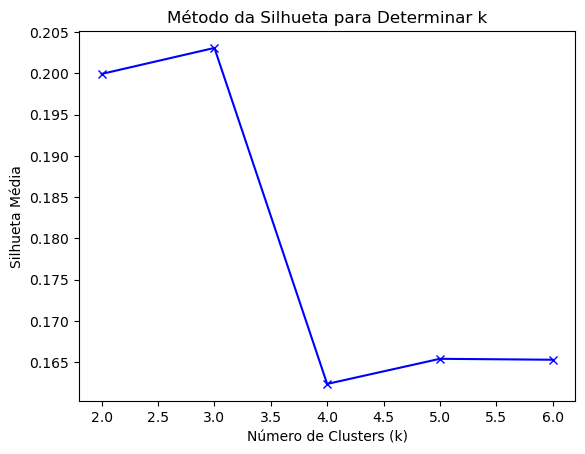

In [63]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Valores de k que você deseja testar
k_values = range(2, 7)

# Lista para armazenar os valores de silhueta média
silhouette_scores = []

# Iterar sobre os valores de k
for k in k_values:
    # Criar o modelo de clustering K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Treinar o modelo nos dados
    kmeans.fit(QuebrasFinal_imputed)
    # Obter as etiquetas de cluster para cada ponto
    labels = kmeans.labels_
    # Calcular o score de silhueta
    silhouette_avg = silhouette_score(QuebrasFinal_imputed, labels)
    # Armazenar o score de silhueta na lista
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico do Método do Cotovelo
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhueta Média')
plt.title('Método da Silhueta para Determinar k')
plt.show()

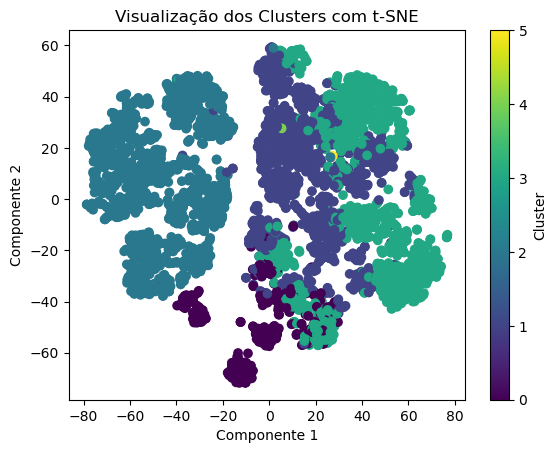

In [68]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduzir a dimensionalidade dos dados para 2 dimensões usando t-SNE
tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(QuebrasFinal_imputed)

# Plotar os pontos em um gráfico de dispersão, colorindo-os de acordo com os clusters
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis')
plt.title('Visualização dos Clusters com t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Cluster')
plt.show()

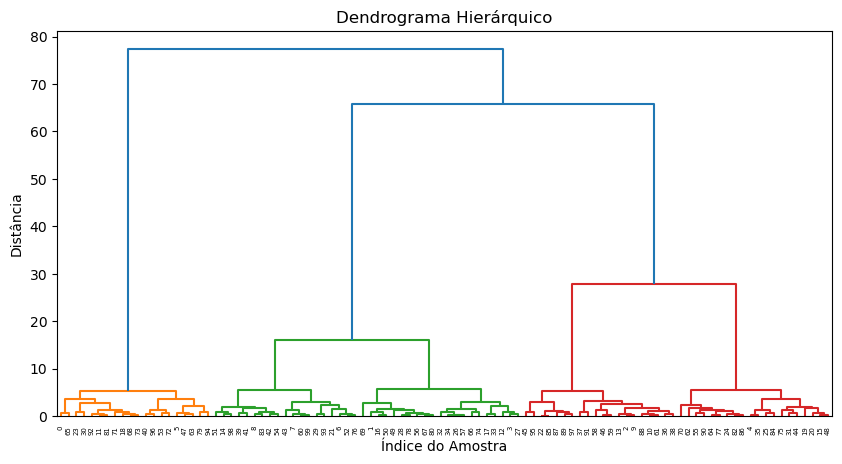

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering

# Gerar dados de exemplo
X, _ = make_blobs(n_samples=100, centers=5, random_state=42)

# Executar o algoritmo de clustering hierárquico
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model.fit(X)

# Função para plotar o dendrograma
def plot_dendrogram(model, **kwargs):
    # Calcula o layout do dendrograma
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # folha
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plota o dendrograma
    dendrogram(linkage_matrix, **kwargs)

# Plotando o dendrograma
plt.figure(figsize=(10, 5))
plt.title('Dendrograma Hierárquico')
plot_dendrogram(model)
plt.xlabel('Índice do Amostra')
plt.ylabel('Distância')
plt.show()

In [70]:
from sklearn.cluster import AgglomerativeClustering

# Inicialize o modelo Agglomerative Clustering com o número desejado de clusters
n_clusters = 3  # Defina o número de clusters desejado
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Ajuste o modelo aos dados
agg_clustering.fit(QuebrasFinal_imputed)

# Obtenha as etiquetas de cluster para cada amostra
cluster_labels = agg_clustering.labels_

# Adicione as etiquetas de cluster ao DataFrame QuebrasFinal_imputed
QuebrasFinal_imputed['Cluster_Agglomerative'] = cluster_labels

In [71]:
QuebrasFinal_imputed['Cluster_Agglomerative'].unique()

array([0, 2, 1], dtype=int64)

In [72]:
QuebrasFinal_imputed

,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,saifi_bt_number,saidi_bt_min,nt,aprovado,...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Cluster_Agglomerative
0,0.244289,42.298595,-0.012112,-0.204619,5.595312,-0.029442,-0.181833,-0.012949,2.738205,1.183332,...,0.555781,-0.031611,-0.406750,0.226092,0.199437,-0.911271,-0.763563,1.096567,3.094735,0
1,-0.079365,-0.001616,-0.013847,-0.204653,-0.036698,-0.029618,-0.181867,-0.013843,0.816457,1.183332,...,0.711698,1.007588,1.856228,0.125321,0.291299,0.668038,-1.532849,-1.548283,-0.364852,0
2,-0.064773,0.220154,-0.013846,-0.204653,-0.031144,-0.029618,-0.181867,-0.013842,0.816457,1.183332,...,0.711698,1.564301,1.654434,1.455498,-1.445101,0.806698,-0.600824,-0.858820,-0.364852,0
3,-0.069637,0.305597,-0.013839,-0.204653,-0.028974,-0.029617,-0.181866,-0.013842,0.816457,1.183332,...,-1.666030,0.914802,0.227460,1.495806,-0.508718,-0.431340,0.689671,1.295750,0.364806,0
4,-0.032594,-0.206193,-0.013844,-0.204653,0.000769,-0.029617,-0.181867,-0.013842,0.816457,1.183332,...,0.711698,-0.254296,-0.853581,0.064859,-1.726925,-1.758516,-1.246072,-0.715182,-0.075505,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,-0.046438,-0.236932,-0.013836,-0.122284,-0.020254,-0.029617,-0.174882,-0.013843,0.816457,1.183332,...,0.711698,0.228189,-0.262612,0.508251,1.227682,0.786890,-0.457436,-0.542817,-0.364852,1
5219,-0.016505,0.386698,-0.013834,-0.062141,0.011015,-0.029617,-0.000964,-0.013835,0.816457,1.183332,...,0.331262,-0.365639,-0.392337,-0.263682,0.973131,1.014689,0.402894,1.152112,1.522195,1
5220,-0.018376,0.109356,-0.013842,-0.024225,0.002429,-0.029617,-0.017727,-0.013837,0.816457,1.183332,...,0.711698,0.024061,-0.161715,0.205938,-0.199620,-0.599713,0.617977,0.232829,-0.339691,1
5221,0.021286,0.070976,-0.013839,0.020882,0.016007,-0.029617,0.029070,-0.013836,0.816457,1.183332,...,0.711698,0.469431,0.270702,0.609022,1.254955,0.460048,-1.246072,-0.887548,-0.364852,1


In [75]:
# Supondo que 'clusters' seja a coluna de clusters em QuebrasFinal_imputed
clusters = QuebrasFinal_imputed['Cluster_Agglomerative']

# Adicionando a coluna de clusters ao DataFrame Quebras
Quebras['Cluster_Agglomerative'] = clusters

In [76]:
Quebras

,codigo_do_relatorio,Concelho,data_do_incidente,causa_do_incidente,duracao_incidente_min,n_o_clientes_afectados,tiepi_mt_min,saifi_mt_number,saidi_mt_min,end_m_wh,...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Cluster_Agglomerative
0,EREDES_2023_NOV_TC_1,Barcelos,2023-11-01 22:30:00+00:00,VENTO INTENSIDADE EXCECIONAL,870.0,244990.0,1.807000,0.053000,2.822000,141.327000,...,0.934426,16.2,19.4,12.7,None,None,None,None,27.5,0
1,EREDES_2023_OUT_T_6,Celorico De Basto,2023-10-09 16:04:00+00:00,VEÍCULOS,5.0,1416.0,0.001451,0.000284,0.001404,0.104147,...,1.000000,21.8,35.1,12.2,242.0,297.0,0.8,4.6,0.0,0
2,EREDES_2023_OUT_T_10,Miranda Do Corvo,2023-10-09 09:43:00+00:00,ABATE DE ÁRVORES POR TERCEIROS,44.0,2693.0,0.002188,0.000105,0.004186,0.157058,...,1.000000,24.8,33.7,18.8,51.0,311.0,2.1,7.0,0.0,0
3,EREDES_2023_OUT_T_12,Matosinhos,2023-10-13 15:25:00+00:00,INTERVENÇÕES NO SUBSOLO (ESCAVAÇÕES),31.0,3185.0,0.010268,0.000347,0.005273,0.736786,...,0.000000,21.3,23.8,19.0,154.0,186.0,3.9,14.5,5.8,0
4,EREDES_2023_OUT_T_13,Santiago Do Cacém,2023-10-22 15:02:00+00:00,CORPOS ESTRANHOS NA REDE,130.0,238.0,0.004813,0.000200,0.020169,0.345438,...,1.000000,15.0,16.3,11.9,20.0,52.0,1.2,7.5,2.3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5218,EDPD_2014_JUN_T_065,Águeda,2014-06-10 00:00:00+00:00,ABATE DE ÁRVORES,93.0,61.0,0.012900,126.000000,0.009640,0.830000,...,1.000000,17.6,20.4,14.1,345.0,309.0,2.3,8.1,0.0,1
5219,EDPD_2014_JUN_T_114,Viseu,2014-06-24 00:00:00+00:00,ABATE DE ÁRVORES,173.0,3652.0,0.014600,218.000000,0.025300,0.950000,...,0.840000,14.4,19.5,None,317.0,332.0,3.5,14.0,15.0,1
5220,EDPD_2014_JUN_T_118,Figueira Da Foz,2014-06-07 00:00:00+00:00,ABATE DE ÁRVORES,168.0,2055.0,0.006640,276.000000,0.021000,0.430000,...,1.000000,16.5,21.1,12.6,188.0,169.0,3.8,10.8,0.2,1
5221,EDPD_2014_JUN_T_124,Porto De Mós,2014-06-18 00:00:00+00:00,DESLIZAMENTO DE TERRAS,274.0,1834.0,0.010100,345.000000,0.027800,0.650000,...,1.000000,18.9,24.1,14.6,348.0,276.0,1.2,6.9,0.0,1


In [106]:
# Criar a tabela pivô
pivot_table = Quebras.pivot_table(index='Concelho', columns='Cluster_Agglomerative', aggfunc='size', fill_value=0)

# Renomear as colunas
pivot_table.columns = ['Cluster_' + str(col) for col in pivot_table.columns]

# Exibir a tabela pivô
pivot_table

,Cluster_0,Cluster_1,Cluster_2
Concelho,,,
Abrantes,21,19,0
Aguiar Da Beira,1,4,0
Alandroal,5,9,0
Albergaria-A-Velha,13,6,0
Albufeira,10,7,0
...,...,...,...
Vouzela,18,13,0
Águeda,30,16,0
Évora,36,9,0


In [99]:
file_path = shape_folder / "concelhos.shp"
Concelho = gpd.read_file(file_path)
Concelho.rename(columns={'NAME_1': 'Distrito'}, inplace=True)
Concelho.rename(columns={'NAME_2': 'Concelho'}, inplace=True)
Concelho["Concelho"] = Concelho["Concelho"].str.title()
Concelho

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,Concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,182,PRT,Portugal,1,Évora,1,Évora,PT.EV.EV,0,0705,Concelho,Municipality,None,None,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506..."
1,182,PRT,Portugal,1,Évora,2,Alandroal,PT.EV.AL,0,0701,Concelho,Municipality,None,None,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343..."
2,182,PRT,Portugal,1,Évora,3,Arraiolos,PT.EV.AR,0,0702,Concelho,Municipality,None,None,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472..."
3,182,PRT,Portugal,1,Évora,4,Borba,PT.EV.BO,0,0703,Concelho,Municipality,None,None,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329..."
4,182,PRT,Portugal,1,Évora,5,Estremoz,PT.EV.ES,0,0704,Concelho,Municipality,None,None,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,182,PRT,Portugal,20,Viseu,302,Tarouca,PT.VI.TR,0,1820,Concelho,Municipality,None,None,"POLYGON ((-7.72591 41.08079, -7.72442 41.08028..."
304,182,PRT,Portugal,20,Viseu,303,Tondela,PT.VI.TO,0,1821,Concelho,Municipality,None,None,"POLYGON ((-8.12772 40.64028, -8.12751 40.64027..."
305,182,PRT,Portugal,20,Viseu,304,Vila Nova De Paiva,PT.VI.VP,0,1822,Concelho,Municipality,None,None,"POLYGON ((-7.77933 40.93439, -7.77835 40.93436..."
306,182,PRT,Portugal,20,Viseu,305,Viseu,PT.VI.VS,0,1823,Concelho,Municipality,None,None,"POLYGON ((-7.80686 40.83789, -7.80653 40.83787..."


In [110]:
Bilada = set(Concelho["Concelho"]) - set(pivot_table.index)
Bilada

{'Alcoutim',
 'Angra Do Heroísmo',
 'Calheta',
 'Corvo',
 'Câmara De Lobos',
 'Funchal',
 'Horta',
 'Lagoa',
 'Lajes Das Flores',
 'Lajes Do Pico',
 'Machico',
 'Madalena',
 'Manteigas',
 'Nordeste',
 'Penedono',
 'Ponta Delgada',
 'Ponta Do Sol',
 'Ponte De Sôr',
 'Porto Moniz',
 'Porto Santo',
 'Povoação',
 'Praia Da Vitória',
 'Ribeira Brava',
 'Ribeira Grande',
 'Santa Cruz',
 'Santa Cruz Da Graciosa',
 'Santa Cruz Das Flores',
 'Santana',
 'São Roque Do Pico',
 'São Vicente',
 'Velas',
 'Vila Do Porto',
 'Vila Franca Do Campo'}

In [100]:
Freguesias_com_clusters = Concelho.merge(pivot_table, left_on='Concelho', right_index=True)
Freguesias_com_clusters

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,Concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry,Cluster_0,Cluster_1,Cluster_2
0,182,PRT,Portugal,1,Évora,1,Évora,PT.EV.EV,0,0705,Concelho,Municipality,None,None,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506...",36,9,0
1,182,PRT,Portugal,1,Évora,2,Alandroal,PT.EV.AL,0,0701,Concelho,Municipality,None,None,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343...",5,9,0
2,182,PRT,Portugal,1,Évora,3,Arraiolos,PT.EV.AR,0,0702,Concelho,Municipality,None,None,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472...",15,2,0
3,182,PRT,Portugal,1,Évora,4,Borba,PT.EV.BO,0,0703,Concelho,Municipality,None,None,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329...",3,2,0
4,182,PRT,Portugal,1,Évora,5,Estremoz,PT.EV.ES,0,0704,Concelho,Municipality,None,None,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066...",5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,182,PRT,Portugal,20,Viseu,302,Tarouca,PT.VI.TR,0,1820,Concelho,Municipality,None,None,"POLYGON ((-7.72591 41.08079, -7.72442 41.08028...",2,2,0
304,182,PRT,Portugal,20,Viseu,303,Tondela,PT.VI.TO,0,1821,Concelho,Municipality,None,None,"POLYGON ((-8.12772 40.64028, -8.12751 40.64027...",17,10,0
305,182,PRT,Portugal,20,Viseu,304,Vila Nova De Paiva,PT.VI.VP,0,1822,Concelho,Municipality,None,None,"POLYGON ((-7.77933 40.93439, -7.77835 40.93436...",5,1,0
306,182,PRT,Portugal,20,Viseu,305,Viseu,PT.VI.VS,0,1823,Concelho,Municipality,None,None,"POLYGON ((-7.80686 40.83789, -7.80653 40.83787...",41,16,0


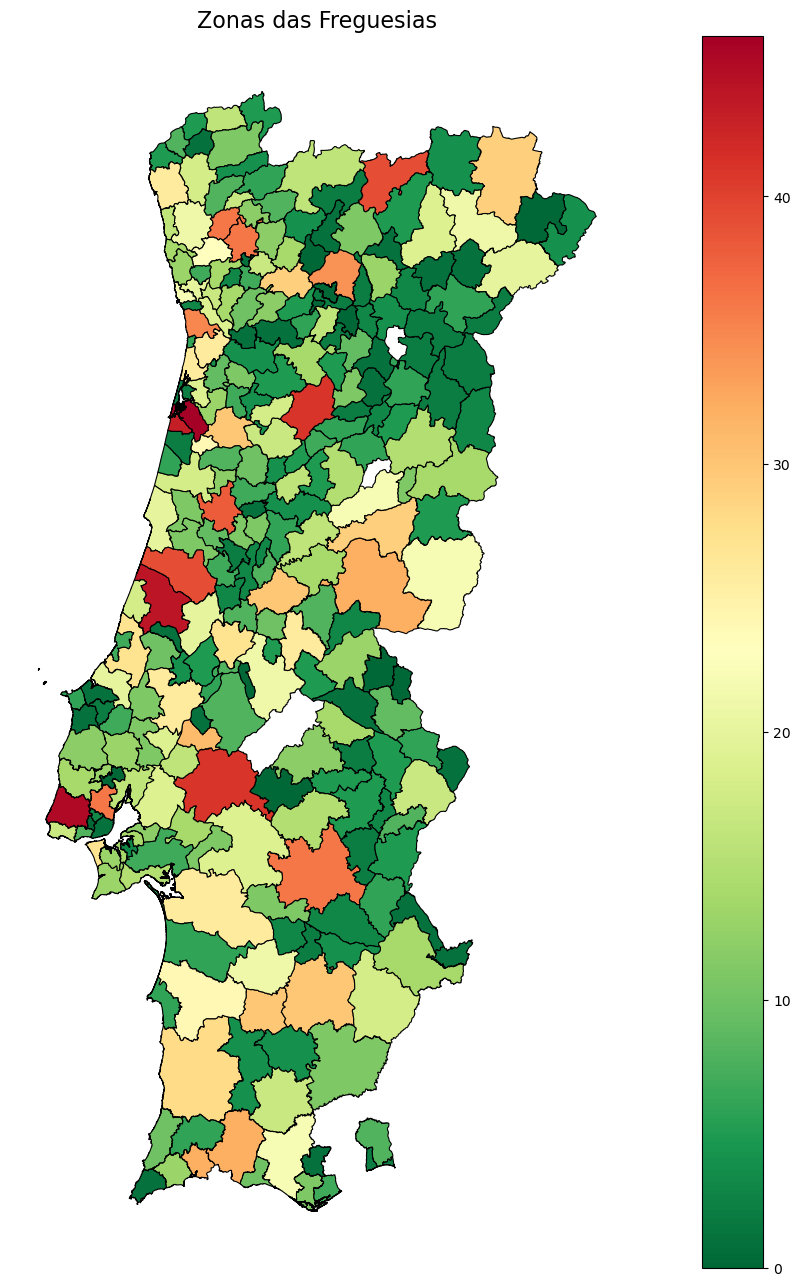

In [101]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(20, 16))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_0', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Remover os eixos
ax.set_axis_off()

# Exibir o mapa
plt.show()

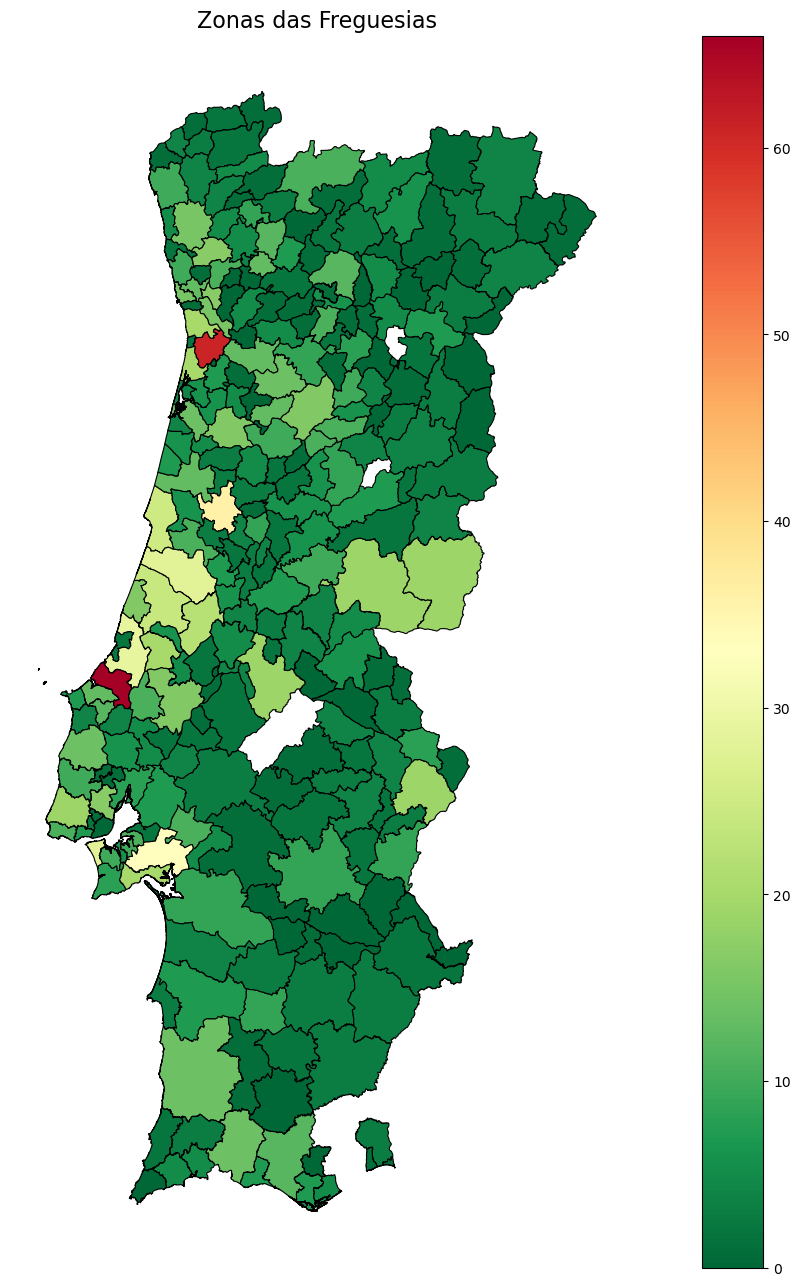

In [102]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(20, 16))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_1', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Remover os eixos
ax.set_axis_off()

# Exibir o mapa
plt.show()

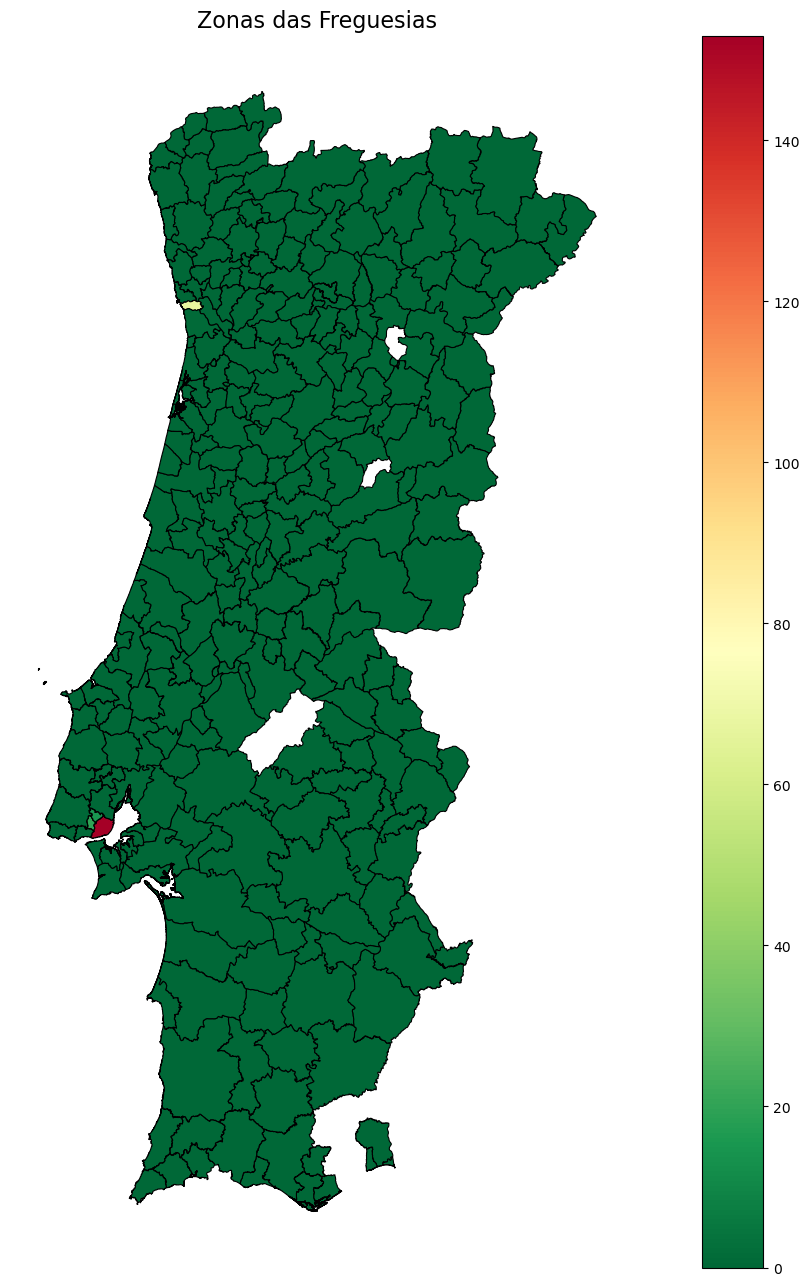

In [103]:
# Configurar a figura e o eixo
fig, ax = plt.subplots(figsize=(20, 16))

# Plotar o mapa das freguesias
Freguesias_com_clusters.plot(column='Cluster_2', cmap = "RdYlGn_r", linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# Adicionar título
ax.set_title('Zonas das Freguesias', fontsize=16)

# Remover os eixos
ax.set_axis_off()

# Exibir o mapa
plt.show()